In [1]:
import spacepy.pycdf as pycdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
L1_AUX = 'cdf_data/20250621/AL1_ASW91_L1_AUX_20250621_UNP_9999_999999_V01.cdf'
L1_TH1 = "cdf_data/20250621/AL1_ASW91_L1_TH1_20250621_UNP_9999_999999_V01.cdf"
L1_TH2 = 'cdf_data/20250621/AL1_ASW91_L1_TH2_20250621_UNP_9999_999999_V01.cdf'
L2_BLK = 'cdf_data/20250621/AL1_ASW91_L2_BLK_20250621_UNP_9999_999999_V02.cdf'
L2_TH1 = 'cdf_data/20250621/AL1_ASW91_L2_TH1_20250621_UNP_9999_999999_V02.cdf'
L2_TH2 = 'cdf_data/20250621/AL1_ASW91_L2_TH2_20250621_UNP_9999_999999_V02.cdf'

In [3]:
import cdflib
import spacepy.pycdf as pycdf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# File paths (update these to your actual file paths)
files = {
    'L1_AUX': 'cdf_data/20250621/AL1_ASW91_L1_AUX_20250621_UNP_9999_999999_V01.cdf',
    'L1_TH1': 'cdf_data/20250621/AL1_ASW91_L1_TH1_20250621_UNP_9999_999999_V01.cdf',
    'L1_TH2': 'cdf_data/20250621/AL1_ASW91_L1_TH2_20250621_UNP_9999_999999_V01.cdf',
    'L2_BLK': 'cdf_data/20250621/AL1_ASW91_L2_BLK_20250621_UNP_9999_999999_V02.cdf',
    'L2_TH1': 'cdf_data/20250621/AL1_ASW91_L2_TH1_20250621_UNP_9999_999999_V02.cdf',
    'L2_TH2': 'cdf_data/20250621/AL1_ASW91_L2_TH2_20250621_UNP_9999_999999_V02.cdf'
}

# Function to load CDF data
def load_cdf(file_path):
    try:
        with cdflib.CDF(file_path) as cdf:
            variables = cdf.var_names()
            data = {}
            for var in variables:
                data[var] = cdf.varget(var)
                fillval = cdf.varattsget(var).get('FILLVAL', -1.0e31)
                if np.isscalar(data[var]):
                    continue
                data[var][data[var] == fillval] = np.nan
                if data[var].ndim > 1 and var not in ['sun_angle_tha1', 'sun_angle_tha2', 'angle_tha1', 'angle_tha2']:
                    data[var] = np.nanmean(data[var], axis=tuple(range(1, data[var].ndim)))
            return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load all datasets
datasets = {key: load_cdf(path) for key, path in files.items()}

# Function to convert epoch to datetime
def epoch_to_datetime(epoch):
    j2000 = datetime(2000, 1, 1, 11, 58, 55, 816000)
    return [j2000 + timedelta(seconds=t / 1e9) for t in epoch]

# Preprocess data
data_frames = {}
for key, data in datasets.items():
    if data is None:
        continue
    epoch_var = 'epoch_for_cdf_mod' if key in ['L1_AUX', 'L1_TH1', 'L1_TH2'] else 'epoch_for_cdf'
    if epoch_var in data:
        times = epoch_to_datetime(data[epoch_var])
        df = pd.DataFrame({'time': times})
        for var in data:
            if var != epoch_var and not np.isscalar(data[var]):
                df[var] = data[var]
        df = df.interpolate(method='time').fillna(method='bfill')
        data_frames[key] = df

# Calculate AHe (Alpha-to-Proton ratio)
for df in data_frames.values():
    if 'proton_density' in df and 'alpha_density' in df:
        df['ahe'] = df['alpha_density'] / (df['proton_density'] + 1e-10)

# Threshold calculation
def calculate_threshold(flux, flux_uncer, window_size=100, k=2, q=99, t_min= Vazquez10):
    epsilon = 1e-10
    flux_log = np.log10(flux + epsilon)
    flux_uncer_log = flux_uncer / (flux + epsilon) / np.log(10)
    p_q = np.percentile(flux_log[-window_size:], q)
    p_25 = np.percentile(flux_log[-window_size:], 25)
    p_75 = np.percentile(flux_log[-window_size:], 75)
    iqr = p_75 - p_25
    threshold_log = p_q + k * (iqr + flux_uncer_log[-1])
    return max(10 ** threshold_log, t_min)

# Apply threshold to L1_TH1 and L1_TH2
for key in ['L1_TH1', 'L1_TH2']:
    if key in data_frames and 'integrated_flux_mod' in data_frames[key]:
        flux = data_frames[key]['integrated_flux_mod']
        flux_uncer = 0.1 * flux  # Proxy for uncertainty
        thresholds = [calculate_threshold(flux[:i+1], flux_uncer[:i+1]) for i in range(len(flux))]
        data_frames[key]['threshold'] = thresholds
        data_frames[key]['is_cme'] = (flux > data_frames[key]['threshold']) & (data_frames[key]['ahe'] > 0.1)

# Visualization - 6 plots
plt.figure(figsize=(15, 20))

# 1. L1_AUX: Proton Density vs. Time
plt.subplot(3, 2, 1)
if 'L1_AUX' in data_frames and 'proton_density' in data_frames['L1_AUX']:
    plt.plot(data_frames['L1_AUX']['time'], data_frames['L1_AUX']['proton_density'], label='Proton Density')
    plt.xlabel('Time')
    plt.ylabel('Proton Density')
    plt.title('L1_AUX: Proton Density')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'L1_AUX Data Unavailable', ha='center', va='center')
    plt.title('L1_AUX: Proton Density')

# 2. L1_TH1: Integrated Flux vs. Time
plt.anaghplt.subplot(3, 2, 2)
if 'L1_TH1' in data_frames and 'integrated_flux_mod' in data_frames['L1_TH1']:
    plt.plot(data_frames['L1_TH1']['time'], data_frames['L1_TH1']['integrated_flux_mod'], label='Integrated Flux')
    plt.plot(data_frames['L1_TH1']['time'], data_frames['L1_TH1']['threshold'], label='Threshold', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.title('L1_TH1: Integrated Flux')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'L1_TH1 Data Unavailable', ha='center', va='center')
    plt.title('L1_TH1: Integrated Flux')

# 3. L1_TH2: Integrated Flux vs. Time
plt.subplot(3, 2, 3)
if 'L1_TH2' in data_frames and 'integrated_flux_mod' in data_frames['L1_TH2']:
    plt.plot(data_frames['L1_TH2']['time'], data_frames['L1_TH2']['integrated_flux_mod'], label='Integrated Flux')
    plt.plot(data_frames['L1_TH2']['time'], data_frames['L1_TH2']['threshold'], label='Threshold', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.title('L1_TH2: Integrated Flux')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'L1_TH2 Data Unavailable', ha='center', va='center')
    plt.title('L1_TH2: Integrated Flux')

# 4. L2_BLK: Angle XGSE vs. Time
plt.subplot(3, 2, 4)
if 'L2_BLK' in data_frames and 'angle_xgse' in data_frames['L2_BLK']:
    plt.plot(data_frames['L2_BLK']['time'], data_frames['L2_BLK']['angle_xgse'], label='Angle XGSE')
    plt.xlabel('Time')
    plt.ylabel('Angle XGSE (°)')
    plt.title('L2_BLK: Angle XGSE')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'L2_BLK Data Unavailable', ha='center', va='center')
    plt.title('L2_BLK: Angle XGSE')

# 5. L2_TH1: THA-1 Spectral Counts vs. Time
plt.subplot(3, 2, 5)
if 'L2_TH1' in datasets and 'THA-1_spec' in datasets['L2_TH1']:
    mean_spec = np.nanmean(datasets['L2_TH1']['THA-1_spec'], axis=(1, 2, 3))
    plt.plot(data_frames['L2_TH1']['time'][:len(mean_spec)], mean_spec, label='Mean Spectral Counts')
    plt.xlabel('Time')
    plt.ylabel('Mean Counts')
    plt.title('L2_TH1: THA-1 Spectral Counts')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'L2_TH1 Data Unavailable', ha='center', va='center')
    plt.title('L2_TH1: THA-1 Spectral Counts')

# 6. L2_TH2: THA-2 Spectral Counts vs. Time
plt.subplot(3, 2, 6)
if 'L2_TH2' in datasets and 'THA-2_spec' in datasets['L2_TH2']:
    mean_spec = np.nanmean(datasets['L2_TH2']['THA-2_spec'], axis=(1, 2))
    plt.plot(data_frames['L2_TH2']['time'][:len(mean_spec)], mean_spec, label='Mean Spectral Counts')
    plt.xlabel('Time')
    plt.ylabel('Mean Counts')
    plt.title('L2_TH2: THA-2 Spectral Counts')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'L2_TH2 Data Unavailable', ha='center', va='center')
    plt.title('L2_TH2: THA-2 Spectral Counts')

plt.tight_layout()
plt.show()

# Print CME detection summary
for key in ['L1_TH1', 'L1_TH2']:
    if key in data_frames and 'is_cme' in data_frames[key]:
        cme_count = data_frames[key]['is_cme'].sum()
        print(f"{key} CME Detections: {cme_count} events on 2025-06-21")
    else:
        print(f"{key} CME Detections: No data available")

Error loading cdf_data/20250621/AL1_ASW91_L1_AUX_20250621_UNP_9999_999999_V01.cdf: 'CDF' object has no attribute 'var_names'
Error loading cdf_data/20250621/AL1_ASW91_L1_TH1_20250621_UNP_9999_999999_V01.cdf: 'CDF' object has no attribute 'var_names'
Error loading cdf_data/20250621/AL1_ASW91_L1_TH2_20250621_UNP_9999_999999_V01.cdf: 'CDF' object has no attribute 'var_names'
Error loading cdf_data/20250621/AL1_ASW91_L2_BLK_20250621_UNP_9999_999999_V02.cdf: 'CDF' object has no attribute 'var_names'
Error loading cdf_data/20250621/AL1_ASW91_L2_TH1_20250621_UNP_9999_999999_V02.cdf: 'CDF' object has no attribute 'var_names'
Error loading cdf_data/20250621/AL1_ASW91_L2_TH2_20250621_UNP_9999_999999_V02.cdf: 'CDF' object has no attribute 'var_names'


NameError: name 'Vazquez10' is not defined

In [4]:
import cdflib
import matplotlib.pyplot as plt

# Read the CDF file
cdf_file = cdflib.CDF(L2_TH2)

# Get the list of variables
variables = cdf_file.cdf_info()['zVariables']
print(variables)

# Extract relevant variables, e.g., flux and time
flux = cdf_file['integrated_flux_mod']
time = cdf_file['epoch_for_cdf_mod']

# Plot the data
plt.plot(time, flux)
plt.xlabel('Time')
plt.ylabel('Integrated Flux')
plt.show()

# Close the file
cdf_file.close()

TypeError: 'CDFInfo' object is not subscriptable

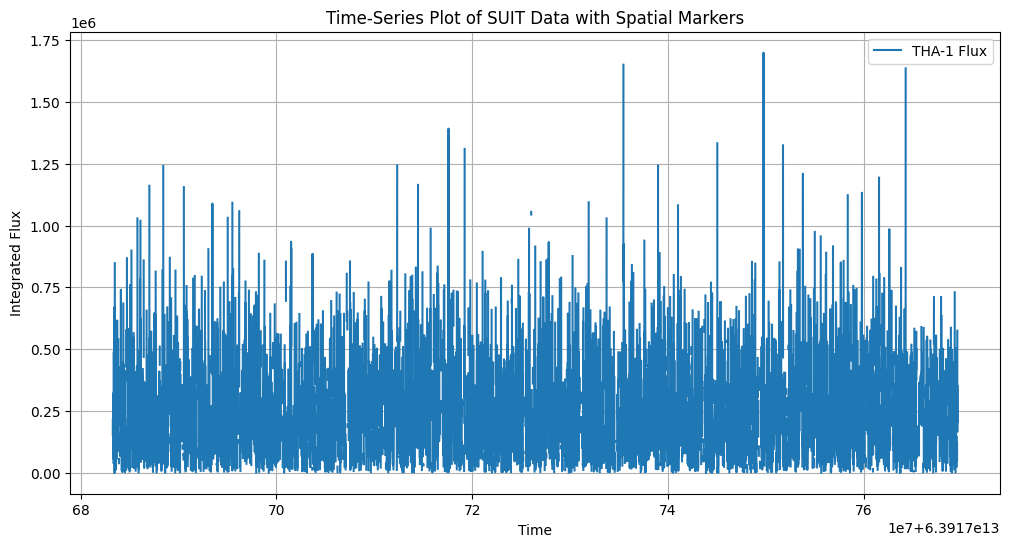

AttributeError: 'CDF' object has no attribute 'close'

In [3]:
import cdflib
import matplotlib.pyplot as plt
import numpy as np

# Read the CDF files
l2_th1_file = cdflib.CDF(L2_TH1)
l2_th2_file = cdflib.CDF(L2_TH2)

# Extract relevant variables
flux_th1 = l2_th1_file['integrated_flux_mod']
time_th1 = l2_th1_file['epoch_for_cdf_mod']
angles_th1 = l2_th1_file['sun_angle_tha1']

flux_th2 = l2_th2_file['integrated_flux_mod']
time_th2 = l2_th2_file['epoch_for_cdf_mod']
angles_th2 = l2_th2_file['sun_angle_tha2']

# Plot the time-series data
plt.figure(figsize=(12, 6))
plt.plot(time_th1, flux_th1[:, 0], label='THA-1 Flux')
directions = ['S', 'W', 'N', 'E']
for i, angle in enumerate(angles_th1[0, :, 0]):
    if angle < -45:
        plt.text(time_th1[0], flux_th1[0, 0], directions[0], ha='center', va='bottom')
    elif -45 <= angle < 45:
        plt.text(time_th1[0], flux_th1[0, 0], directions[1], ha='center', va='bottom')
    elif 45 <= angle < 135:
        plt.text(time_th1[0], flux_th1[0, 0], directions[2], ha='center', va='bottom')
    else:
        plt.text(time_th1[0], flux_th1[0, 0], directions[3], ha='center', va='bottom')

plt.xlabel('Time')
plt.ylabel('Integrated Flux')
plt.title('Time-Series Plot of SUIT Data with Spatial Markers')
plt.legend()
plt.grid(True)
plt.show()

# Close the CDF files
l2_th1_file.close()
l2_th2_file.close()

In [3]:
from src.preprocessing_cdf_file import *
L2_BLK_data = pycdf.CDF(L2_BLK)
L1_AUX_data = pycdf.CDF(L1_AUX)
L2_TH1_data = pycdf.CDF(L2_TH1)
L2_TH2_data = pycdf.CDF(L2_TH2)
L1_TH1_data = pycdf.CDF(L1_TH1)
L1_TH2_data = pycdf.CDF(L1_TH2)

In [ ]:
time = pd.DataFrame()

In [4]:
L2_BLK_data, L2_TH1_data, L2_TH2_data

(<CDF:
 alpha_bulk_speed: CDF_DOUBLE [17275]
 alpha_density: CDF_DOUBLE [17275]
 alpha_thermal: CDF_DOUBLE [17275]
 bulk_a_uncer: CDF_DOUBLE [17275]
 bulk_p_uncer: CDF_DOUBLE [17275]
 epoch_for_cdf_mod: CDF_EPOCH [17275]
 numden_a_uncer: CDF_DOUBLE [17275]
 numden_p_uncer: CDF_DOUBLE [17275]
 proton_bulk_speed: CDF_DOUBLE [17275]
 proton_density: CDF_DOUBLE [17275]
 proton_thermal: CDF_DOUBLE [17275]
 proton_xvelocity: CDF_DOUBLE [17275]
 proton_yvelocity: CDF_DOUBLE [17275]
 proton_zvelocity: CDF_DOUBLE [17275]
 spacecraft_xpos: CDF_DOUBLE [17275]
 spacecraft_ypos: CDF_DOUBLE [17275]
 spacecraft_zpos: CDF_DOUBLE [17275]
 thermal_a_uncer: CDF_DOUBLE [17275]
 thermal_p_uncer: CDF_DOUBLE [17275]
 >,
 <CDF:
 energy_center_mod: CDF_DOUBLE [17275, 50]
 energy_uncer: CDF_DOUBLE [] NRV
 epoch_for_cdf_mod: CDF_EPOCH [17275]
 flux_uncer: CDF_DOUBLE [] NRV
 integrated_flux_mod: CDF_DOUBLE [17275, 50]
 integrated_flux_s10_mod: CDF_DOUBLE [17275, 50]
 integrated_flux_s11_mod: CDF_DOUBLE [17275, 50

In [14]:
# L1_TH2
time_raw = pd.DataFrame(L1_TH2_data['epoch_for_cdf'])
flux_raw = pd.DataFrame(L1_TH2_data['THA-2_spec'][:,0])
# L1_AUX
angle_tha2 = pd.DataFrame(L1_AUX_data['angle_tha2'][:,0])

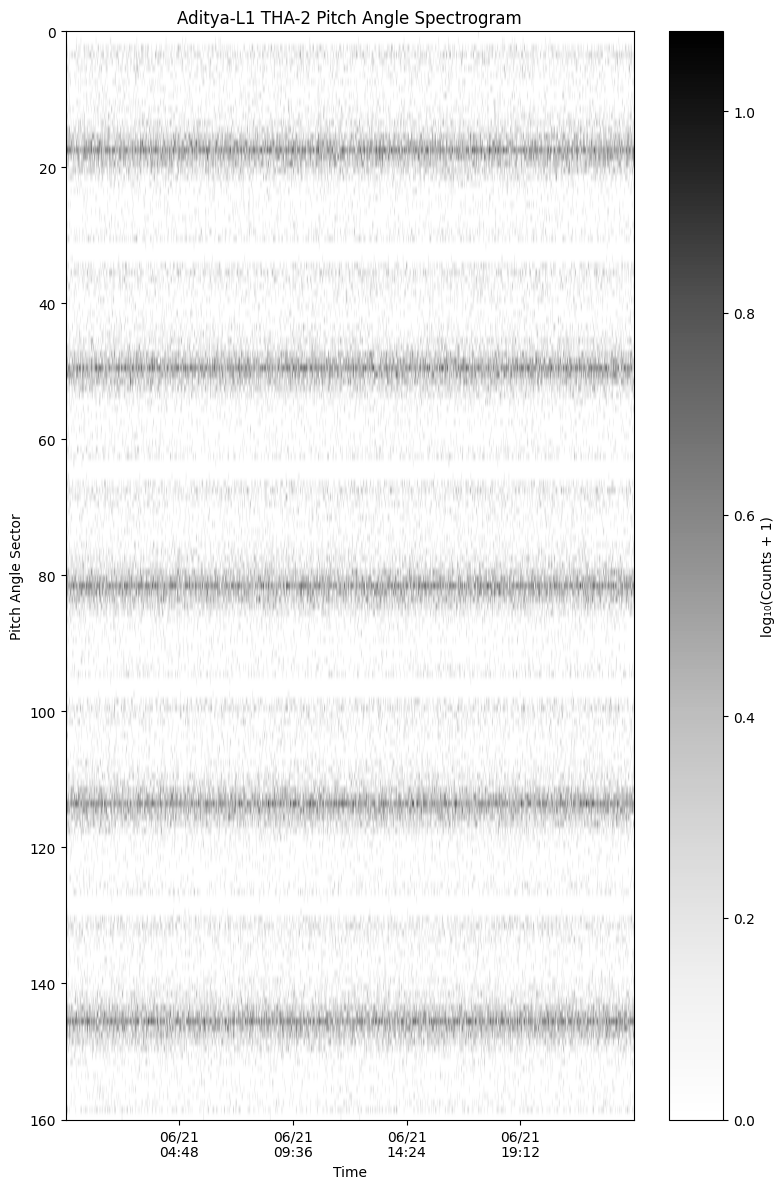

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming L1_TH2_data and L1_AUX_data are dictionaries from your CDFs
# Use only one energy channel (e.g., index 0)
flux_raw = L1_TH2_data['THA-2_spec'][:, 0, :]  # shape: [time, sector]
time_raw = L1_TH2_data['epoch_for_cdf'][:, 0]  # shape: [time]

# Subsample for visualization
stride = 100
flux = flux_raw[::stride]  # shape: [T, sector]
time = time_raw[::stride]

# Convert time to datetime
time_series = pd.to_datetime(time)

# Plot
plt.figure(figsize=(8, 12))
plt.imshow(np.log10(flux.T + 1), aspect='auto', cmap='Greys',
           extent=[mdates.date2num(time_series[0]),
                   mdates.date2num(time_series[-1]),
                   flux.shape[1], 0])  # sectors on Y axis

plt.colorbar(label='log₁₀(Counts + 1)')
plt.ylabel('Pitch Angle Sector')
plt.xlabel('Time')
plt.title('Aditya-L1 THA-2 Pitch Angle Spectrogram')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
plt.tight_layout()
plt.show()


In [5]:
L1_AUX_data, L1_TH1_data, L1_TH2_data

(<CDF:
 DC_temp_mon: CDF_UINT2 [172786, 3]
 ESA1_HV: CDF_UINT2 [172786, 5]
 ESA1_HV_set: CDF_UINT2 [172786, 5]
 ESA2_HV_mon: CDF_UINT2 [172786, 5]
 ESA2_HV_set: CDF_UINT2 [172786, 5]
 FEE_cal_chn: CDF_UINT2 [172786]
 FEE_cal_mode: CDF_UINT2 [172786]
 FEE_volt_mon: CDF_UINT2 [172786, 4]
 Focus: CDF_UINT2 [172786, 5]
 Focus_set: CDF_UINT2 [172786, 5]
 HV_PCB_temp_mon: CDF_UINT2 [172786, 5]
 HV_pack_mon: CDF_UINT2 [172786, 2]
 HW_LLD: CDF_UINT2 [172786, 5]
 MCP1_HV: CDF_UINT2 [172786, 5]
 MCP1_HV_set: CDF_UINT2 [172786]
 MCP1_PHD_mode: CDF_UINT2 [172786]
 MCP1_curr_mon: CDF_UINT2 [172786, 5]
 MCP1_curr_override: CDF_UINT2 [172786]
 MCP1_curr_trip: CDF_UINT2 [172786]
 MCP1_spike_override: CDF_UINT2 [172786]
 MCP1_spike_trip: CDF_UINT2 [172786]
 MCP1_start_comm: CDF_UINT2 [172786]
 MCP1_status: CDF_UINT2 [172786]
 MCP1_trip_check: CDF_UINT2 [172786]
 MCP2_HV_mon: CDF_UINT2 [172786, 5]
 MCP2_HV_set: CDF_UINT2 [172786]
 MCP2_PHD_mode: CDF_UINT2 [172786]
 MCP2_curr_mon: CDF_UINT2 [172786, 5]
 

In [2]:
def detect_cme_events(df, speed_threshold=500, min_duration=1800, sw_speed_min=200):
    """Detect CME events and calculate their properties."""
    # Filter for solar wind conditions
    df_sw = df[df['proton_bulk_speed'] > sw_speed_min].copy()
    if df_sw.empty:
        return pd.DataFrame()

    # Calculate distance from spacecraft to Earth (assuming GSE coordinates, Earth at (0,0,0), units in km)
    df_sw['distance'] = np.sqrt(df_sw['spacecraft_xpos']**2 + df_sw['spacecraft_ypos']**2 + df_sw['spacecraft_zpos']**2)

    # Calculate dynamic pressure (P_dyn in nPa)
    df_sw['P_dyn'] = 1.67e-6 * df_sw['proton_density'] * df_sw['proton_bulk_speed']**2

    # Detect periods above speed threshold
    df_sw['above_threshold'] = df_sw['proton_bulk_speed'] > speed_threshold
    df_sw['event_id'] = (df_sw['above_threshold'] != df_sw['above_threshold'].shift()).cumsum()

    # Group by event_id and aggregate
    events = df_sw[df_sw['above_threshold']].groupby('event_id').agg(
        start_time=('time', 'min'),
        end_time=('time', 'max'),
        duration=('time', lambda x: (x.max() - x.min()).total_seconds()),
        average_speed=('proton_bulk_speed', 'mean'),
        max_P_dyn=('P_dyn', 'max'),
        first_distance=('distance', 'first'),
        first_speed=('proton_bulk_speed', 'first')
    ).reset_index()

    # Filter events by minimum duration
    cme_events = events[events['duration'] > min_duration].copy()
    if cme_events.empty:
        return pd.DataFrame()

    # Calculate travel time and arrival time
    cme_events['t_travel'] = cme_events['first_distance'] / cme_events['first_speed']  # seconds
    cme_events['arrival_time'] = cme_events['start_time'] + pd.to_timedelta(cme_events['t_travel'], unit='s')

    return cme_events

In [3]:
from src.preprocessing_cdf_file import *

sample_data = prepare_data(L2_BLK)
sample_data.head()

,time,proton_bulk_speed,alpha_bulk_speed,alpha_density,alpha_thermal,proton_density,proton_thermal,proton_xvelocity,proton_yvelocity,proton_zvelocity,spacecraft_xpos,spacecraft_ypos,spacecraft_zpos
0,2025-06-21 00:00:27.241,527.811778,527.717540,0.021293,70.616460,0.472894,58.119399,-527.811778,40.998300,74.362111,1.273305e+06,-53303.976497,-106259.083118
1,2025-06-21 00:00:32.241,531.641873,530.457707,0.023811,74.685536,0.585398,60.660295,-531.641873,50.764305,75.093527,1.273305e+06,-53302.489909,-106259.097312
2,2025-06-21 00:00:37.241,522.361542,523.665670,0.018445,79.021363,0.352802,54.211246,-522.361542,60.206399,78.753785,1.273305e+06,-53301.003230,-106259.111507
3,2025-06-21 00:00:42.241,517.219492,514.952105,0.022309,84.295291,0.373367,60.227005,-517.219492,42.802706,75.764355,1.273306e+06,-53299.516581,-106259.125700
4,2025-06-21 00:00:47.241,511.407907,509.242297,0.019262,76.823608,0.376295,53.585891,-511.407907,41.228391,68.502695,1.273306e+06,-53298.029960,-106259.139893


In [7]:
sample_data.shape

(17275, 13)

In [4]:
sample_data.columns

Index(['time', 'proton_bulk_speed', 'alpha_bulk_speed', 'alpha_density',
       'alpha_thermal', 'proton_density', 'proton_thermal', 'proton_xvelocity',
       'proton_yvelocity', 'proton_zvelocity', 'spacecraft_xpos',
       'spacecraft_ypos', 'spacecraft_zpos'],
      dtype='object')

In [6]:
detect_cme_events(sample_data)

,event_id,start_time,end_time,duration,average_speed,max_P_dyn,first_distance,first_speed,t_travel,arrival_time
36,73,2025-06-21 05:09:57.405,2025-06-21 08:06:47.503,10610.098,551.875567,1.615098,1.278804e+06,507.251227,2521.046546,2025-06-21 05:51:58.451546039
37,75,2025-06-21 08:35:17.519,2025-06-21 18:12:17.844,34620.325,531.482627,1.777860,1.278790e+06,535.017108,2390.184577,2025-06-21 09:15:07.703577064
50,101,2025-06-21 19:41:57.891,2025-06-21 23:55:53.025,15235.134,536.625427,1.800428,1.278805e+06,506.018304,2527.190951,2025-06-21 20:24:05.081950561


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from spacepy import pycdf
import matplotlib.dates as mdates

# Load CDF File
cdf_file = pycdf.CDF('your_file.cdf')

# Read relevant variables (adjust keys as per actual file)
time = cdf_file['epoch'][...]  # Time axis
pitch_angles = cdf_file['pitch_angle'][...]  # e.g., [0, 45, 90, 135, 180]
flux = cdf_file['flux'][...]  # Shape: (time, pitch_angle)

# Convert time to matplotlib date format
from spacepy import time as spt
time_dt = spt.Ticktock(time, 'CDF').UTC

# Create the plot
plt.figure(figsize=(8, 12))
plt.imshow(np.log10(flux.T + 1e-2), aspect='auto', cmap='Greys',
           extent=[mdates.date2num(time_dt[0]), mdates.date2num(time_dt[-1]), 
                   pitch_angles[-1], pitch_angles[0]])

plt.colorbar(label='log₁₀(Flux)')
plt.ylabel('Pitch Angle (°)')
plt.xlabel('Time')
plt.title('Pitch Angle Spectrogram (Aditya-L1 SWIS)')
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
plt.tight_layout()
plt.show()
